In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
sys.path.append('../python/')

#matplotlib for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')

#other computational libraries
import numpy as np
import pandas as pd
import scipy
import scipy.constants as co
import scipy.stats as ss
from scipy.ndimage import shift
import itertools
import pickle
from pathlib import Path

from lmfit.models import GaussianModel, LinearModel

In [2]:
import pickle
#how to read
#fileObj = open('data/r76-80V-naitrig-100eV-goodchi.pkl', 'rb')
fileObj = open('data/r76_events_coincidencepeak_LE.pkl', 'rb')
exampleObj = pickle.load(fileObj)
fileObj.close()
print(exampleObj)

                                                                    Z1  \
                                                                    QI   
72209162200 20309    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            40339    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            50269    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            60108    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            60849    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
...                                                                ...   
72209172155 2020326  [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            2020591  [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            2030429  [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            2060050  [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            2060679  [65532, 65532, 65532, 65532, 65532, 65532, 655...   

                                     

In [3]:
import statistics as st
def isRailed(v):
    if(np.isnan(v).any()):
        return True
    if(st.mode(v)==0):
        return True
    return False

In [4]:
#'../coin_analysis/data/r76-coinpeak-lt-50keV.txt'
import pulseAnalysis as pa

pulse_struct = pa.parseEventList('../coin_analysis/data/r76-coinpeak-lt-50keV.txt')

series_numbers = []
event_numbers = []

for series, events in pulse_struct.items():
    for event in events:
        # Convert series to string, remove underscore, and convert to integer
        series_number = int(str(series).replace('_', ''))
        
        # Append series number and event number to their respective lists
        series_numbers.append(series_number)
        event_numbers.append(event)
        
print("AAAAAAAAAAAAAAAAAAAAAAAAAA",series_numbers)
#pulse_struct = sps.parseEventList('../coin_analysis/data/r76_events_coincidencepeak.txt')

   SeriesNumber  EventNumber
0   72209162200        20309
1   72209162200        40339
2   72209162200        50269
3   72209162200        60108
4   72209162200        60849
5   72209162200        80307
6   72209162200       100246
7   72209162200       110588
8   72209162200       110617
9   72209162200       120647
[72209162200 72209171225 72209172155]
[  20309   40339   50269   60108   60849   80307  100246  110588  110617
  120647  120688  130460  140628  150823  160296  170423  180002  180423
  230432  240270  270221  340151  340912  380054  380186  390511  420391
  420816  430710  440168  480387  480389  500725  520930  540170  540903
  550322  560707  560931  570415  580008  580723  590121  610172  610663
  610684  640653  650751  670228  670650  690338  710437  740337  750334
  750490  760179  770287  780145  780259  780278  780628  800530  810923
  820568  840012  840222  850265  860663  880573  880913  910282  920809
  920948  930239  930872  940631  950888  960920  970767 10

In [5]:
import copy

coindata = pd.read_csv("../coin_analysis/data/r76_events_coincidencepeak.txt", skiprows=3, engine='python',skipfooter=1,sep="*",skipinitialspace=True, \
            index_col=False, \
            names=['garbage','Row','SeriesNumber','EventNumber','PTOFdelay','pt_keVee'], \
            delim_whitespace=False)

series_nums = np.asarray(coindata['SeriesNumber'])
event_nums = np.asarray(coindata['EventNumber'])
EkeV = np.asarray(coindata['pt_keVee'])
PTOFdelay = np.asarray(coindata['PTOFdelay'])
sers=copy.deepcopy(series_nums)
evs=copy.deepcopy(event_nums)

newPTOF=[]
newE=[]
newEv=[]
newSer=[]
tacohut=evs*10000+sers
pizzabell = []
for event, series in zip(event_numbers, series_numbers):
    pizzabell.append(event*10000 + series)

for i,s in enumerate(tacohut):
    if(tacohut[i] in pizzabell):
        newPTOF.append(PTOFdelay[i])
        newE.append(EkeV[i])
        newEv.append(evs[i])
        newSer.append(sers[i])
        
print(len(newPTOF))


def getEnergy(series,ev):
    energy = 0

    for i in range(0, len(series_nums)):
        if series_nums[i] == series:
            if event_nums[i] == ev:
                energy = (EkeV[i])
    return energy

def getBaseline(ptpulse):
    
    x = np.linspace(100, 250, 150)
    #print(len(x))
    y = ptpulse[100:250]
    #print(len(y))
    
    #print(x)
    #print(y)
    
    baseline_model = np.polyfit(x, y, 1)
    baseline_model_fn = np.poly1d(baseline_model)
    
    return(baseline_model_fn)

1156


In [6]:
# ax1.fill_between(np.arange(0, best_cross + 1), bshifted_pT[:best_cross + 1], 0, color='gray', alpha=0.5)
                
              #      area = np.trapz(bshifted_pT[:best_cross + 1], dx=1)
                #    print("Area:", area)
def getPTPulse(pulses,series=72209162200,ev=20309,chan=[('Z1','PA'),('Z1','PB'),('Z1','PD'),('Z3','PA'),('Z3','PB'),('Z3','PD')]):
    ptpulse=[]
    ccount=0
    for c in chan:
        #print(c[0])
        pulse = pulses[c[0]][c[1]][series,ev]
        if(isRailed(pulse)):
            continue
        mean = np.mean(pulse[100:])
        #print(mean)
        pulse = pulse-mean
        #print(pulse)
        #print(np.size(ptpulse))
        if(ccount==0):
            ptpulse=pulse
        else:
            ptpulse+=pulse
        ccount+=1
        
    return ptpulse


def getPTPulseCD(pulses,series=72209162200,ev=20309):
    
    pulse = getPTPulse(pulses, series, ev)

    #adding discriminator
    D = 100

    end_values = pulse[3997:]
    
    CD_pulse = shift(pulse, D, cval=np.nan)

    #adding the cut off values to the front of the new pulse
    CD_pulse[0:99] = end_values
    #print(new_pulse)
        
    return CD_pulse

[ 56  50  14 ...   9 -11 -21]


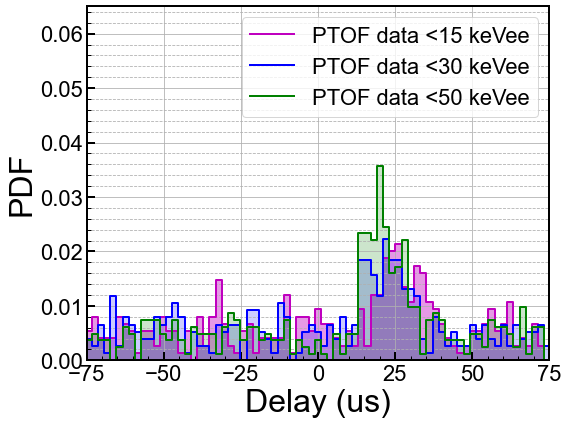

In [7]:
newnewE=np.asarray(newE)
newnewPTOF=np.asarray(newPTOF)
print(newnewPTOF)
lowE=(newnewE<15)
medE= (newnewE>15) & (newnewE<30)
hiE=(newnewE>30)

#filtered_delay = (delay>0)

qbins = np.linspace(-200,200,200)
xcq = (qbins[:-1] + qbins[1:]) / 2
#n,nx = np.histogram(delay,bins=qbins)
n_org, nx_org = np.histogram(newnewPTOF[lowE],bins=qbins)
n_org1, nx_org1 = np.histogram(newnewPTOF[medE],bins=qbins)
n_org2, nx_org2 = np.histogram(newnewPTOF[hiE],bins=qbins)



#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(8.0,6.0),sharex=True)
ax1 = axes

#yhist = n/np.sum(n)/np.diff(xcq)[0]

yhist_org = n_org/np.sum(n_org)/np.diff(xcq)[0]
yhist_org1 = n_org1/np.sum(n_org1)/np.diff(xcq)[0]
yhist_org2 = n_org2/np.sum(n_org2)/np.diff(xcq)[0]



#plotting new delays
#ax1.step(xcq,yhist, where='mid',color='b', linestyle='-', \
 #           label='constant discriminator', linewidth=2)
#ax1.fill_between(xcq,np.zeros(np.shape(xcq)),yhist,step='mid',facecolor='b',alpha=0.4, \
 #                label='')

# plotting original delays
ax1.step(xcq,yhist_org, where='mid',color='m', linestyle='-', \
            label='PTOF data <15 keVee', linewidth=2)
ax1.fill_between(xcq,np.zeros(np.shape(xcq)),yhist_org,step='mid',facecolor='m',alpha=0.4, \
                 label='')

ax1.step(xcq,yhist_org1, where='mid',color='blue', linestyle='-', \
            label='PTOF data <30 keVee', linewidth=2)
ax1.fill_between(xcq,np.zeros(np.shape(xcq)),yhist_org1,step='mid',facecolor='blue',alpha=0.2, \
                 label='')

ax1.step(xcq,yhist_org2, where='mid',color='green', linestyle='-', \
            label='PTOF data <50 keVee', linewidth=2)
ax1.fill_between(xcq,np.zeros(np.shape(xcq)),yhist_org2,step='mid',facecolor='green',alpha=0.2, \
                 label='')

# fitting histograms
#new_fit, new_center, new_width = fit_hist(delay, 110)
#print(new_center, new_width)
#org_fit, org_center, org_width = fit_hist(PTOFdelay[cHE], 25)
#print(org_center, org_width)

# normalizing fits
#new_fit_plot = new_fit.best_fit/np.sum(new_fit.best_fit)/np.diff(xcq)[0]
#org_fit_plot = org_fit.best_fit/np.sum(org_fit.best_fit)/np.diff(xcq)[0]

#ax1.plot(xcq, new_fit_plot, color = 'k', linestyle='--', label='')
#ax1.plot(xcq, org_fit_plot, color = 'k', linestyle='--', label='')

#blue = '#118DFA'
ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(-75, 75) 
ax1.set_ylim(0.0, 0.065)
ax1.set_xlabel(r'Delay (us)')
ax1.set_ylabel('PDF')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/MSyieldHist_Figure3a.eps')
#plt.savefig('paper_figures/MSyieldHist_Figure3a.pdf')
plt.show()


In [8]:
def getBadBL_PTOF(pulses, series, ev):
    pulse = getPTPulseCD(pulses, series, ev)
    asdf = np.linspace(150, 300)
    asdfg = pulse[np.round(asdf).astype(int)]  # Round and convert to int
    asdf1 = np.linspace(2500, 3000)
    asdfg1 = pulse[np.round(asdf1).astype(int)]  # Round and convert to int
    lowBinAvg = np.mean(asdfg)
    hiBinAvg = np.mean(asdfg1)
    if np.abs(hiBinAvg - lowBinAvg) > 500:
        return False
    else:
        return True
        
def getBadBL(obj, series=72209162200, ev=20309):
    pT = getPTPulseCD(obj,series,ev)+3000
    baseline = getBaseline(pT)
    xB = np.linspace(0, 4095, 4096)
    yB = baseline(xB)
        #print(ser)

        
        #baseline discriminator - weird diagonal pulses
    bshifted_pT = np.subtract(pT,yB)
    asdf = np.linspace(150, 300) 
    asdfg = bshifted_pT[np.round(asdf).astype(int)]  
    asdf1 = np.linspace(2500, 3000)
    asdfg1 = bshifted_pT[np.round(asdf1).astype(int)]  
    lowBinAvg = np.mean(asdfg)
    #print("lo avg", lowBinAvg)
    hiBinAvg = np.mean(asdfg1)
    #print("hi avg", hiBinAvg)
    if ((hiBinAvg - lowBinAvg) > 500) or ((hiBinAvg - lowBinAvg)<-170):#upsloping/downsloping bl should have different thrs
        return False
    else:
        return True

In [9]:
goodDelays=[]
goodEs=[]

print(len(series_numbers))
print(len(newnewPTOF))
print(len(event_numbers))

for i,x in enumerate(newnewPTOF):
    
    if getBadBL_PTOF(exampleObj, series_numbers[i], event_numbers[i]):
        goodDelays.append(x)
        goodEs.append(newnewE[i])
            


1156
1156
1156


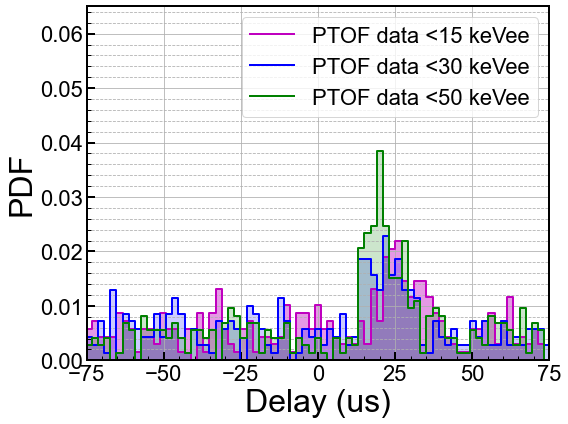

In [10]:
goodDelays = np.array(goodDelays)
goodEs=np.array(goodEs)
# Define energy ranges
lowE = (goodEs < 15)
medE = (goodEs > 15) & (goodEs < 30)
hiE = (goodEs > 30)

# Define bins
qbins = np.linspace(-200, 200, 200)
xcq = (qbins[:-1] + qbins[1:]) / 2

# Create histograms for each energy range
n_lowE, _ = np.histogram(goodDelays[lowE], bins=qbins)
n_medE, _ = np.histogram(goodDelays[medE], bins=qbins)
n_hiE, _ = np.histogram(goodDelays[hiE], bins=qbins)
n_all,_=np.histogram(goodDelays, bins=qbins)

# Normalize histograms
yhist_lowE = n_lowE / np.sum(n_lowE) / np.diff(xcq)[0]
yhist_medE = n_medE / np.sum(n_medE) / np.diff(xcq)[0]
yhist_hiE = n_hiE / np.sum(n_hiE) / np.diff(xcq)[0]
yhist_all = n_all/np.sum(n_all)/np.diff(xcq)[0]
# Plotting
fig, ax1 = plt.subplots(figsize=(8.0, 6.0))

# Plot histograms for each energy range
ax1.step(xcq, yhist_lowE, where='mid', color='m', linestyle='-', label='PTOF data <15 keVee', linewidth=2)
ax1.fill_between(xcq, np.zeros_like(xcq), yhist_lowE, step='mid', facecolor='m', alpha=0.4, label='')

ax1.step(xcq, yhist_medE, where='mid', color='blue', linestyle='-', label='PTOF data <30 keVee', linewidth=2)
ax1.fill_between(xcq, np.zeros_like(xcq), yhist_medE, step='mid', facecolor='blue', alpha=0.2, label='')

ax1.step(xcq, yhist_hiE, where='mid', color='green', linestyle='-', label='PTOF data <50 keVee', linewidth=2)
ax1.fill_between(xcq, np.zeros_like(xcq), yhist_hiE, step='mid', facecolor='green', alpha=0.2, label='')

#ax1.step(xcq, yhist_all, where='mid', color='black', linestyle='--', label='all PTOF data with BL cut', linewidth=2)
# Set plot properties
ax1.set_yscale('linear')
ax1.set_xlim(-75, 75)
ax1.set_ylim(0.0, 0.065)
ax1.set_xlabel(r'Delay (us)')
ax1.set_ylabel('PDF')
ax1.grid(True)
ax1.yaxis.grid(True, which='minor', linestyle='--')
ax1.legend(loc=1, prop={'size': 22})

for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.show()

In [11]:
loops = 0
time_reg = []
time_reg_cut=[]
energies = []
energies_cut=[]
bad=[]
goodevs=[]
plot = False

for s in pulse_struct:
    ser=int(s.replace('_',''))
    for ev in pulse_struct[s]:
        
        #print(exampleObj['Z1']['PA'][ser,ev])
        energy = getEnergy(ser, ev)
        
        shownpulses=0
        
        #if energy > 51:
        #    continue
        #print(ser)

        #plt.subplot(8,12)
        if(not isRailed(exampleObj['Z1']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PA'][ser,ev],label="pC") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z1']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PB'][ser,ev],label="pF")
        if(not isRailed(exampleObj['Z1']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PD'][ser,ev],label="pE")
        if(not isRailed(exampleObj['Z3']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PA'][ser,ev],label="pB") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z3']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PB'][ser,ev],label="pA")
        if(not isRailed(exampleObj['Z3']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PD'][ser,ev],label="pD")
            
        pT = getPTPulseCD(exampleObj,ser,ev)+3000
        baseline = getBaseline(pT)
        xB = np.linspace(0, 4095, 4096)
        yB = baseline(xB)
        #print(ser)

        
        #baseline discriminator - weird diagonal pulses
        bshifted_pT = np.subtract(pT,yB)

        if(shownpulses>0):
                        
            crosses = np.isclose(bshifted_pT, 0, atol=75.0) #changed from 250
            
            #t = 0
            #for i in range(0,750):
            #    if (crosses[i] == True):
            #        time_reg.append(i)
            #        #print("Crosses at bin: " + str(i))
            #        energies.append(energy)
                    #t += 1
            #        break
                    
            best_cross = 0
            plot_cross = False
            
            for i in range(0, 1000):
                if (crosses[i] == True):
                    best_cross = i 
                    
            if best_cross != 0:
                time_reg.append(best_cross)
                energies.append(energy)
                if getBadBL(exampleObj,ser,ev):
                    time_reg_cut.append(best_cross)
                    energies_cut.append(energy)
                
                #t += 1
                plot_cross = True
                
                    
            if (plot==True) and (not getBadBL(exampleObj,ser,ev)) and (energy<15):
                
                print("Series Number: " + str(ser))
                print("Event Number: " + str(ev))
                print("Energy: " + str(energy) + " keV")
        
                fig,axes = plt.subplots(1,1,figsize=(10.0,8.0),sharex=True)
                ax1 = axes
                
                ax1.plot(bshifted_pT, label="pT")
                #ax1.plot(xB, yB, color='r', linestyle="--", label="baseline")
                plt.axhline(y=0, color='g', linestyle="--")
                
                #ax1.plot((exampleObj['Z4']['PA'][ser,ev]/3)+2900-2650)
                #plt.title('PA')
                ax1.legend(loc=1,prop={'size':22})
                ax1.set_xlim(0,4096)
                ax1.set_xlabel('Bin')
                ax1.set_ylabel('Trace amplitude')
                plt.axvline(x=500,color='k',linestyle="--")
                
                if plot_cross == True:
                    ax1.plot(best_cross, 0, 'ro')
                    
                    fixedWidth=160
                    fixedWidth1=400
                    ax1.fill_betweenx(ax1.get_ylim(), 500, 500+fixedWidth1, color='orange', alpha=0.5)
                    ax1.fill_betweenx(ax1.get_ylim(), 500, 500+fixedWidth, color='gray', alpha=0.5)

                if shownpulses > 0:
                    #plt.savefig(f'figures/{energy}_keV_pulse.png')
                    plt.show()
                    
            #if t == 0:
            #    time_reg.append(0)
            
            loops += 1

In [12]:
time_reg_array = np.asarray(time_reg)
time_reg_array_cut = np.asarray(time_reg_cut)

delay = []
delay_cut=[]
filt_energies = []
filt_energies_cut=[]

for i in range(len(time_reg_array)):
    #if (time_reg_array[i]-500) > 0:
    delay.append(time_reg_array[i]-500)
    filt_energies.append(energies[i])
for i in range(len(time_reg_array_cut)):
    #if (time_reg_array[i]-500) > 0:
    delay_cut.append(time_reg_array_cut[i]-500)
    filt_energies_cut.append(energies_cut[i])

#print(delay)
print(loops, len(delay))

1156 1156


1156


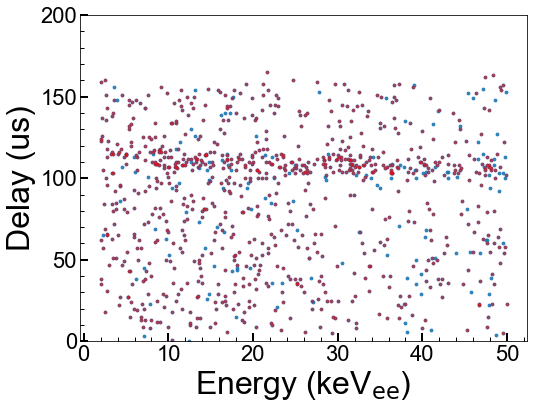

In [13]:
fig, axs = plt.subplots(1,1,figsize=(8,6))
ax1 = axs

print(len(filt_energies))
#print(len(delay))

ax1.scatter(filt_energies, delay, marker='o', alpha=0.9, s=8)
ax1.scatter(filt_energies_cut,delay_cut, marker='o', alpha=0.4, s=7, color='red')

ax1.set(xlabel="Energy (keV$_{\mathrm{ee}}$)", ylabel="Delay (us)")
    
#plt.xlim(0, 200)
plt.ylim(0,200)

#saving to output file
df = pd.DataFrame({'energy':filt_energies, 'delay':delay})

filepath = Path('output/below_50_dis.csv')  
df.to_csv(filepath, index=False)  

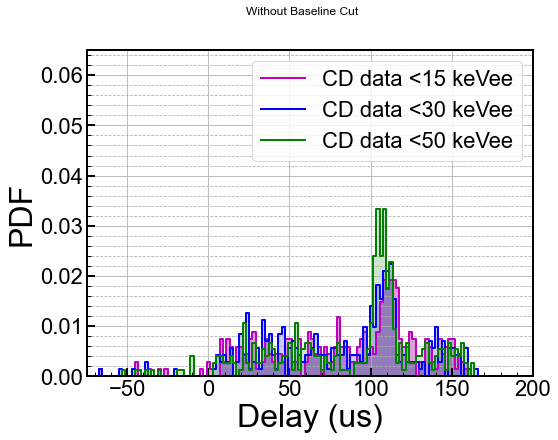

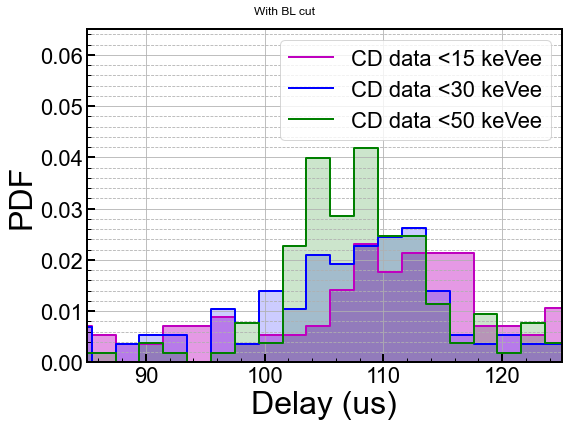

In [14]:
filt_energies_array=np.asarray(filt_energies)
filt_energies_cut_array=np.asarray(filt_energies_cut)
delay1=np.asarray(delay)
delay_cut1=np.asarray(delay_cut)

# Define energy ranges
lowE = (filt_energies_array < 15)
medE = (filt_energies_array > 15) & (filt_energies_array < 30)
hiE = (filt_energies_array > 30)

lowE_cut = (filt_energies_cut_array < 15)
medE_cut = (filt_energies_cut_array > 15) & (filt_energies_cut_array < 30)
hiE_cut = (filt_energies_cut_array > 30)

# Define bins
qbins = np.linspace(-200, 200, 200)
xcq = (qbins[:-1] + qbins[1:]) / 2

# Create histograms for each energy range
n_lowE, _ = np.histogram(delay1[lowE], bins=qbins)
n_medE, _ = np.histogram(delay1[medE], bins=qbins)
n_hiE, _ = np.histogram(delay1[hiE], bins=qbins)
n_all,_=np.histogram(delay1, bins=qbins)

n_lowE_cut, _ = np.histogram(delay_cut1[lowE_cut], bins=qbins)
n_medE_cut, _ = np.histogram(delay_cut1[medE_cut], bins=qbins)
n_hiE_cut, _ = np.histogram(delay_cut1[hiE_cut], bins=qbins)

# Normalize histograms
yhist_lowE = n_lowE / np.sum(n_lowE) / np.diff(xcq)[0]
yhist_medE = n_medE / np.sum(n_medE) / np.diff(xcq)[0]
yhist_hiE = n_hiE / np.sum(n_hiE) / np.diff(xcq)[0]
yhist_all = n_all/np.sum(n_all)/np.diff(xcq)[0]

yhist_lowE_cut = n_lowE_cut / np.sum(n_lowE_cut) / np.diff(xcq)[0]
yhist_medE_cut = n_medE_cut / np.sum(n_medE_cut) / np.diff(xcq)[0]
yhist_hiE_cut = n_hiE_cut / np.sum(n_hiE_cut) / np.diff(xcq)[0]
# Plotting
fig1, ax1 = plt.subplots(figsize=(8.0, 6.0))
fig2, ax2 = plt.subplots(figsize=(8.0, 6.0))
fig1.suptitle('Without Baseline Cut')
fig2.suptitle('With BL cut')

# Plot histograms for each energy range
ax1.step(xcq, yhist_lowE, where='mid', color='m', linestyle='-', label='CD data <15 keVee', linewidth=2)
ax1.fill_between(xcq, np.zeros_like(xcq), yhist_lowE, step='mid', facecolor='m', alpha=0.4, label='')

ax1.step(xcq, yhist_medE, where='mid', color='blue', linestyle='-', label='CD data <30 keVee', linewidth=2)
ax1.fill_between(xcq, np.zeros_like(xcq), yhist_medE, step='mid', facecolor='blue', alpha=0.2, label='')

ax1.step(xcq, yhist_hiE, where='mid', color='green', linestyle='-', label='CD data <50 keVee', linewidth=2)
ax1.fill_between(xcq, np.zeros_like(xcq), yhist_hiE, step='mid', facecolor='green', alpha=0.2, label='')

ax2.step(xcq, yhist_lowE_cut, where='mid', color='m', linestyle='-', label='CD data <15 keVee', linewidth=2)
ax2.fill_between(xcq, np.zeros_like(xcq), yhist_lowE_cut, step='mid', facecolor='m', alpha=0.4, label='')

ax2.step(xcq, yhist_medE_cut, where='mid', color='blue', linestyle='-', label='CD data <30 keVee', linewidth=2)
ax2.fill_between(xcq, np.zeros_like(xcq), yhist_medE_cut, step='mid', facecolor='blue', alpha=0.2, label='')

ax2.step(xcq, yhist_hiE_cut, where='mid', color='green', linestyle='-', label='CD data <50 keVee', linewidth=2)
ax2.fill_between(xcq, np.zeros_like(xcq), yhist_hiE_cut, step='mid', facecolor='green', alpha=0.2, label='')

#ax1.step(xcq, yhist_all, where='mid', color='black', linestyle='--', label='all PTOF data with BL cut', linewidth=2)
# Set plot properties
ax1.set_yscale('linear')
ax1.set_xlim(-75, 200)
ax1.set_ylim(0.0, 0.065)
ax1.set_xlabel(r'Delay (us)')
ax1.set_ylabel('PDF')
ax1.grid(True)
ax1.yaxis.grid(True, which='minor', linestyle='--')
ax1.legend(loc=1, prop={'size': 22})

for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(2)
    
    
ax2.set_yscale('linear')
ax2.set_xlim(85, 125)
ax2.set_ylim(0.0, 0.065)
ax2.set_xlabel(r'Delay (us)')
ax2.set_ylabel('PDF')
ax2.grid(True)
ax2.yaxis.grid(True, which='minor', linestyle='--')
ax2.legend(loc=1, prop={'size': 22})

for axis in ['top', 'bottom', 'left', 'right']:
    ax2.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.show()

#futurebugs make sure u didnt get it backwards

Series Number: 72209162200
Event Number: 4390531
Energy: 30.91563502985 keV


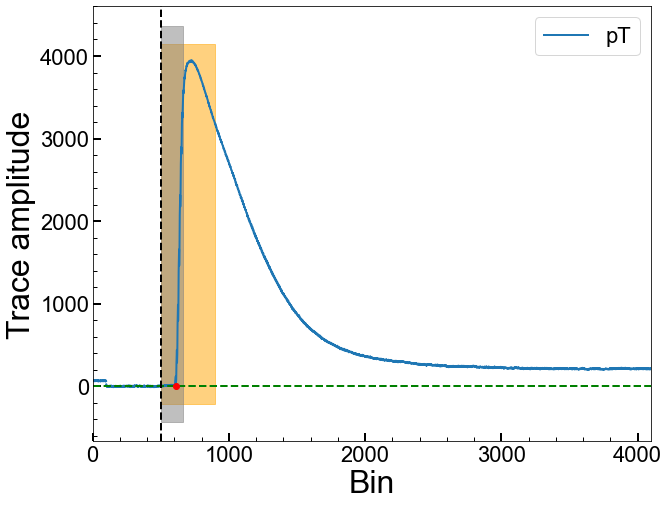

Series Number: 72209162200
Event Number: 4460275
Energy: 40.24675471532 keV


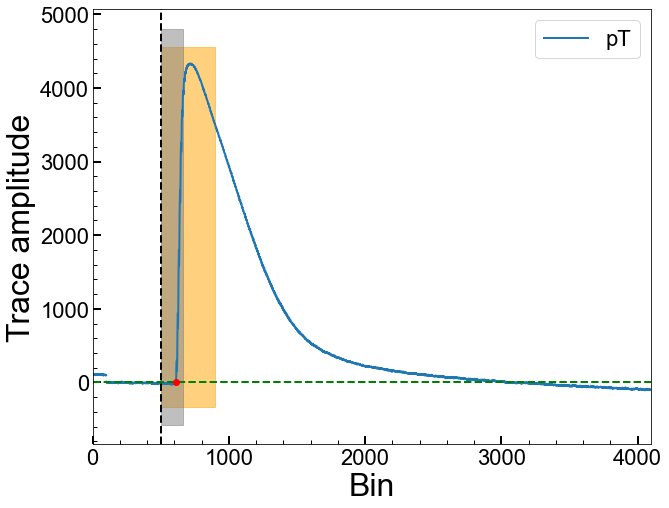

Series Number: 72209162200
Event Number: 7000910
Energy: 38.34920513826 keV


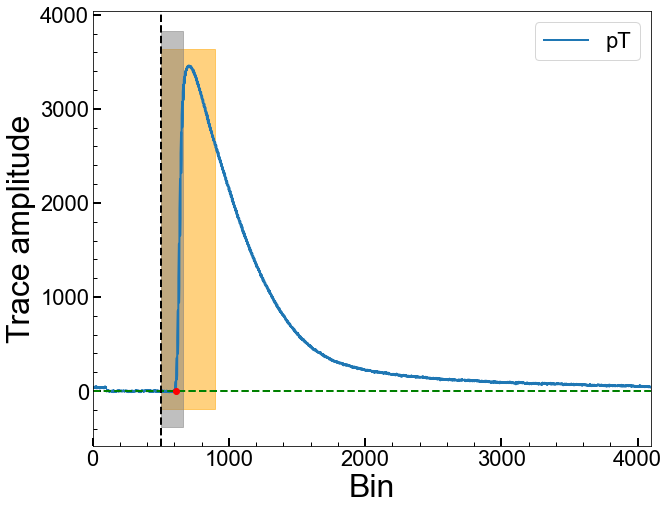

Series Number: 72209171225
Event Number: 1780911
Energy: 31.23113488654 keV


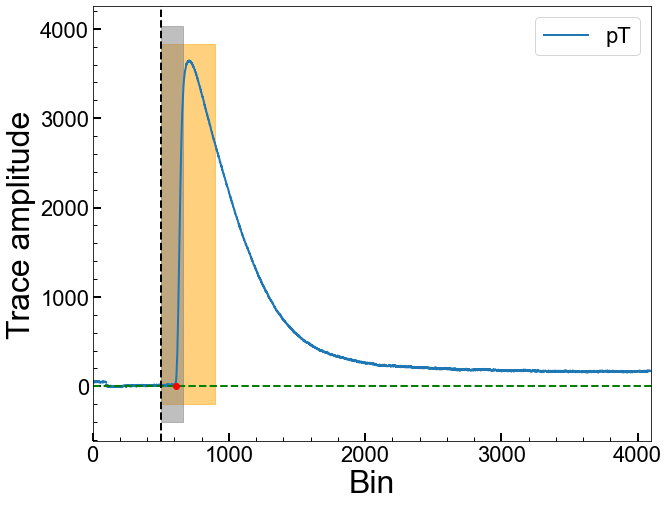

Series Number: 72209172155
Event Number: 850204
Energy: 46.0506657719 keV


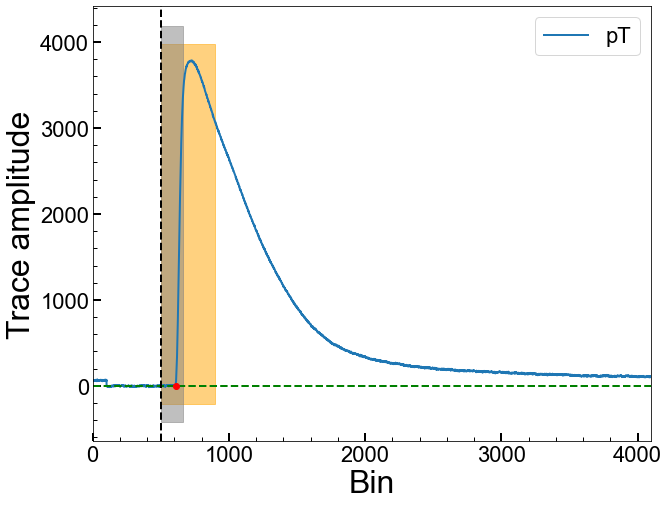

In [16]:
#plot low E pulses with delay range between 110 and 120 us
loops = 0
time_reg = []
time_reg_cut=[]
energies = []
energies_cut=[]
bad=[]
goodevs=[]
plot = True

for s in pulse_struct:
    ser=int(s.replace('_',''))
    for ev in pulse_struct[s]:
        
        #print(exampleObj['Z1']['PA'][ser,ev])
        energy = getEnergy(ser, ev)
        
        shownpulses=0
        
        #if energy > 51:
        #    continue
        #print(ser)

        #plt.subplot(8,12)
        if(not isRailed(exampleObj['Z1']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PA'][ser,ev],label="pC") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z1']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PB'][ser,ev],label="pF")
        if(not isRailed(exampleObj['Z1']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PD'][ser,ev],label="pE")
        if(not isRailed(exampleObj['Z3']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PA'][ser,ev],label="pB") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z3']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PB'][ser,ev],label="pA")
        if(not isRailed(exampleObj['Z3']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PD'][ser,ev],label="pD")
            
        pT = getPTPulseCD(exampleObj,ser,ev)+3000
        baseline = getBaseline(pT)
        xB = np.linspace(0, 4095, 4096)
        yB = baseline(xB)
        #print(ser)

        
        #baseline discriminator - weird diagonal pulses
        bshifted_pT = np.subtract(pT,yB)

        if(shownpulses>0):
                        
            crosses = np.isclose(bshifted_pT, 0, atol=75.0) #changed from 250
            
            #t = 0
            #for i in range(0,750):
            #    if (crosses[i] == True):
            #        time_reg.append(i)
            #        #print("Crosses at bin: " + str(i))
            #        energies.append(energy)
                    #t += 1
            #        break
                    
            best_cross = 0
            plot_cross = False
            
            for i in range(0, 1000):
                if (crosses[i] == True):
                    best_cross = i 
                    
            if best_cross != 0:
                time_reg.append(best_cross)
                energies.append(energy)
                if getBadBL(exampleObj,ser,ev):
                    time_reg_cut.append(best_cross)
                    energies_cut.append(energy)
                
                #t += 1
                plot_cross = True
                
                    
            if (plot==True) and (best_cross>111+500) and (best_cross<113+500) and (energy>30) and (getBadBL(exampleObj,ser,ev)):
                
                print("Series Number: " + str(ser))
                print("Event Number: " + str(ev))
                print("Energy: " + str(energy) + " keV")
        
                fig,axes = plt.subplots(1,1,figsize=(10.0,8.0),sharex=True)
                ax1 = axes
                
                ax1.plot(bshifted_pT, label="pT")
                #ax1.plot(xB, yB, color='r', linestyle="--", label="baseline")
                plt.axhline(y=0, color='g', linestyle="--")
                
                #ax1.plot((exampleObj['Z4']['PA'][ser,ev]/3)+2900-2650)
                #plt.title('PA')
                ax1.legend(loc=1,prop={'size':22})
                ax1.set_xlim(0,4096)
                ax1.set_xlabel('Bin')
                ax1.set_ylabel('Trace amplitude')
                plt.axvline(x=500,color='k',linestyle="--")
                
                if plot_cross == True:
                    ax1.plot(best_cross, 0, 'ro')
                    
                    fixedWidth=160
                    fixedWidth1=400
                    ax1.fill_betweenx(ax1.get_ylim(), 500, 500+fixedWidth1, color='orange', alpha=0.5)
                    ax1.fill_betweenx(ax1.get_ylim(), 500, 500+fixedWidth, color='gray', alpha=0.5)

                if shownpulses > 0:
                    #plt.savefig(f'figures/{energy}_keV_pulse.png')
                    plt.show()
                    
            #if t == 0:
            #    time_reg.append(0)
            
            loops += 1